# Data dictionary

- bathroom - bathroomcnt
- bedroom - bedroomcnt 
- square_feet - calculatedfinishedsquarefeet: there are multiple columns related to square footage; I chose this one because all of the others had much more NULL data, and did not include anything new
- tax - taxamount: we use taxamount to later calculate tax rates per county
- fips - (Federal Information Processing Standards): we included the fips column because that's what we use to find the county.
- house_value - taxvaluedollarcnt: we use taxvaluedollarcnt as property value because it includes land and structure

In [1]:
import pandas as pd
import numpy as np
from env import get_db_url
import evaluate, split_scale
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.formula.api import ols
from math import sqrt

# Data acquisition

In [2]:
url = get_db_url('zillow')
query = ('''
SELECT bathroomcnt AS bathroom, bedroomcnt AS bedroom, 
    calculatedfinishedsquarefeet AS square_feet, taxamount AS tax, 
    fips, taxvaluedollarcnt AS house_value 
FROM properties_2017
JOIN predictions_2017 USING (parcelid)
WHERE propertylandusetypeid = 261
    AND (transactiondate >= '2017-05-01' AND 
         transactiondate <= '2017-06-31')
''')
df_orig = pd.read_sql(query, url)

In [3]:
counties = pd.read_table('FIPS.txt', header=1)
counties.columns = ['FIPS', 'county', 'state']
counties.head()

,FIPS,county,state
0,1001,Autauga,AL
1,1003,Baldwin,AL
2,1005,Barbour,AL
3,1007,Bibb,AL
4,1009,Blount,AL


# Data Preparation

In [4]:
df = df_orig.copy()
df.head(10)

,bathroom,bedroom,square_feet,tax,fips,house_value
0,2.0,3.0,1458.0,2319.90,6037.0,136104.0
1,1.0,2.0,1421.0,543.69,6037.0,35606.0
2,3.0,4.0,2541.0,9819.72,6059.0,880456.0
3,2.0,3.0,1650.0,7673.19,6037.0,614000.0
4,1.0,2.0,693.0,3267.47,6037.0,274237.0
5,0.0,0.0,1378.0,2135.39,6037.0,168828.0
6,2.0,3.0,1668.0,2376.34,6059.0,196483.0
7,2.5,3.0,1653.0,6185.28,6059.0,605000.0
8,1.0,3.0,879.0,2015.78,6059.0,141875.0
9,2.0,3.0,1108.0,5990.50,6037.0,486866.0


In [5]:
df = pd.merge(df, counties, left_on='fips', 
                 right_on='FIPS', how='left')
df.drop(columns='fips', inplace=True)
df.head()

,bathroom,bedroom,square_feet,tax,house_value,FIPS,county,state
0,2.0,3.0,1458.0,2319.90,136104.0,6037,Los Angeles,CA
1,1.0,2.0,1421.0,543.69,35606.0,6037,Los Angeles,CA
2,3.0,4.0,2541.0,9819.72,880456.0,6059,Orange,CA
3,2.0,3.0,1650.0,7673.19,614000.0,6037,Los Angeles,CA
4,1.0,2.0,693.0,3267.47,274237.0,6037,Los Angeles,CA


In [6]:
df.isnull().sum()

bathroom        0
bedroom         0
square_feet    24
tax             1
house_value     0
FIPS            0
county          0
state           0
dtype: int64

In [7]:
df.shape[0]

15036

In [8]:
bathroom_std = df.bathroom.std()
bedroom_std = df.bedroom.std()
square_feet_std = df.square_feet.std()
house_value_std = df.house_value.std()

df.bedroom = df.bedroom[(df.bedroom <= bedroom_std * 5) &
                       (df.bedroom != 0)]
df.bathroom = df.bathroom[(df.bathroom <= bathroom_std * 5) &
                        (df.bathroom != 0) ]
df.square_feet = df.square_feet[
    (df.square_feet <= square_feet_std * 5) &
    (df.square_feet >= square_feet_std * .2)]
df.house_value = df.house_value[
    (df.house_value <= house_value_std * 5) & 
    (df.house_value >= house_value_std * .2)]

This data contains many points which I consider wild outliers. I chose to remove all data points that were above or below 10 standard deviations of each variable. I also removed the data points where bedroom or bathroom were listed as 0.

In [9]:
df.isnull().sum()

bathroom        270
bedroom        1418
square_feet     246
tax               1
house_value    2911
FIPS              0
county            0
state             0
dtype: int64

This is how many data points I found to be extreme outliers, and so removed

In [10]:
df.dropna(inplace=True)
df.shape[0]

10801

In [11]:
df.square_feet = df.square_feet.astype(int)
df.bedroom = df.bedroom.astype(int)
df.house_value = df.house_value.astype(int)

In [12]:
df.head()

,bathroom,bedroom,square_feet,tax,house_value,FIPS,county,state
2,3.0,4,2541,9819.72,880456,6059,Orange,CA
3,2.0,3,1650,7673.19,614000,6037,Los Angeles,CA
4,1.0,2,693,3267.47,274237,6037,Los Angeles,CA
6,2.0,3,1668,2376.34,196483,6059,Orange,CA
7,2.5,3,1653,6185.28,605000,6059,Orange,CA


# Data exploration

In [13]:
train, test = split_scale.split_my_data(df, .8)
train.head()

,bathroom,bedroom,square_feet,tax,house_value,FIPS,county,state
5597,4.0,4,3662,26579.60,2206585,6037,Los Angeles,CA
11432,1.0,3,1295,5925.28,462980,6037,Los Angeles,CA
3389,1.0,3,1220,6093.43,500000,6037,Los Angeles,CA
1991,1.0,2,928,6237.20,533299,6037,Los Angeles,CA
1165,2.0,3,1417,6425.21,532195,6037,Los Angeles,CA


## Null Hypothesis:
##### There is no correlation between bathroom count being low (less than 3) and house value

In [14]:
x = train[(train.bathroom < 3)].house_value
mu = train.house_value.mean()
t_stat, p = stats.ttest_1samp(x, mu)
t_stat, p

(-23.843917458940076, 3.7572849599417486e-120)

This t statistic being so far from 0 means we should reject our null hypothesis

In [15]:
r, p = stats.pearsonr(train.bathroom, train.house_value)
r, p

(0.42333196049897814, 0.0)

This high r value indicates a high correlation between bathroom count and house value

In [16]:
r, p = stats.pearsonr(train.bedroom, train.house_value)
r, p

(0.17179642023854635, 3.1895369536284264e-58)

This relatively small r value indicates that there is a low correlation between bedroom count and house value

In [17]:
r, p = stats.pearsonr(train.square_feet, train.house_value)
r, p

(0.5213624072152458, 0.0)

This high r value indicates a very high correlation between square footage and house value

In [18]:
train.head()

,bathroom,bedroom,square_feet,tax,house_value,FIPS,county,state
5597,4.0,4,3662,26579.60,2206585,6037,Los Angeles,CA
11432,1.0,3,1295,5925.28,462980,6037,Los Angeles,CA
3389,1.0,3,1220,6093.43,500000,6037,Los Angeles,CA
1991,1.0,2,928,6237.20,533299,6037,Los Angeles,CA
1165,2.0,3,1417,6425.21,532195,6037,Los Angeles,CA


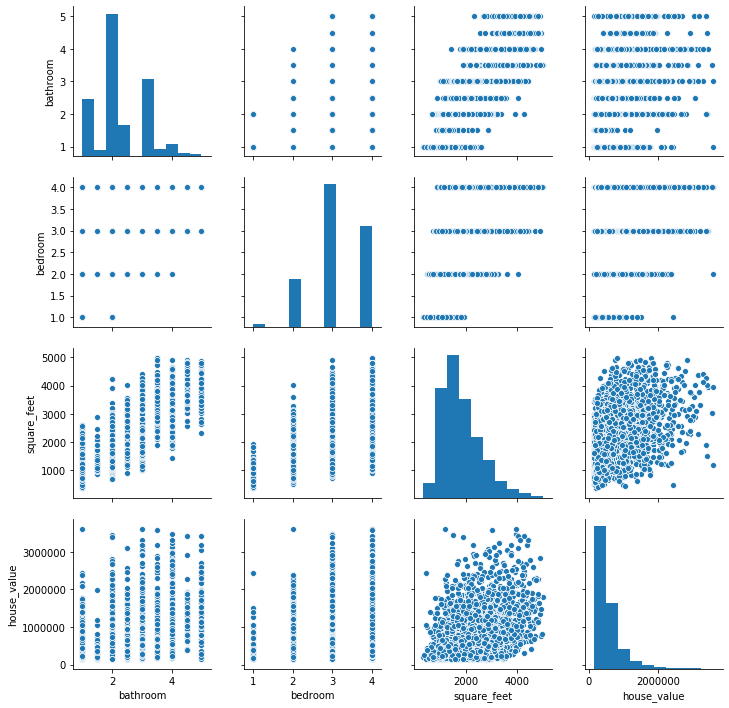

In [19]:
train2 = train.copy()
train2.drop(columns=['county', 'tax', 'state', 'FIPS'], inplace=True)
sns.pairplot(train2)

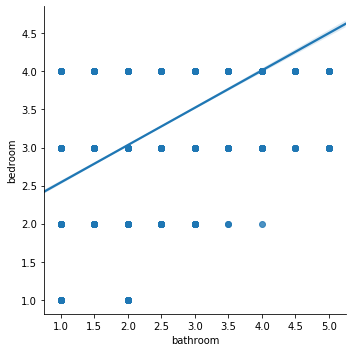

In [20]:
sns.lmplot('bathroom', 'bedroom', train)

This graph implies a likely correlation between bedroom and bathroom, so it would be best to not use both in predicting house value. Bathroom is shown to have a much better correlation with the independent variable as shown in the pairplot above, so I will be using a model that does not use bedroom.

In [21]:
train.head()

,bathroom,bedroom,square_feet,tax,house_value,FIPS,county,state
5597,4.0,4,3662,26579.60,2206585,6037,Los Angeles,CA
11432,1.0,3,1295,5925.28,462980,6037,Los Angeles,CA
3389,1.0,3,1220,6093.43,500000,6037,Los Angeles,CA
1991,1.0,2,928,6237.20,533299,6037,Los Angeles,CA
1165,2.0,3,1417,6425.21,532195,6037,Los Angeles,CA


# Feature engineering and Modeling

In [22]:
X_train = train[['bathroom', 'bedroom', 'square_feet']]
y_train = train.house_value

In [23]:
selector = SelectKBest(f_regression, k=2)
selector.fit(X_train, y_train)
X2 = selector.transform(X_train)

support = selector.get_support()
X_train.columns[support].tolist()

['bathroom', 'square_feet']

In [24]:
rfe = RFE(LinearRegression(), 2)
X_rfe = rfe.fit_transform(X_train, y_train)
mask = rfe.support_
X_train.columns[mask].tolist()

['bathroom', 'bedroom']

In [25]:
predictions = pd.DataFrame({'actual': train.house_value})
predictions.head()

,actual
5597,2206585
11432,462980
3389,500000
1991,533299
1165,532195


In [26]:
predictions['base_average'] = train.house_value.mean()
predictions.base_average = predictions.base_average.astype(int)
predictions.head()

,actual,base_average
5597,2206585,550803
11432,462980,550803
3389,500000,550803
1991,533299,550803
1165,532195,550803


In [27]:
#Using all 3 features
simple_lm_all = LinearRegression()
simple_lm_all.fit(X_train, y_train)
predictions['simple_lm_all'] = simple_lm_all.predict(X_train)
predictions.simple_lm_all = predictions.simple_lm_all.astype(int)
predictions.head()

,actual,base_average,simple_lm_all
5597,2206585,550803,1085036
11432,462980,550803,356741
3389,500000,550803,333150
1991,533299,550803,345325
1165,532195,550803,424380


In [28]:
# Using the two features suggested by SelectKBest
X = train[['bathroom', 'square_feet']]

simple_lm_k2 = LinearRegression()
simple_lm_k2.fit(X, y_train)
predictions['simple_lm_k2'] = simple_lm_k2.predict(X)
predictions.simple_lm_k2 = predictions.simple_lm_k2.astype(int)
predictions.head()

,actual,base_average,simple_lm_all,simple_lm_k2
5597,2206585,550803,1085036,1067884
11432,462980,550803,356741,393046
3389,500000,550803,333150,371727
1991,533299,550803,345325,288723
1165,532195,550803,424380,428391


In [29]:
lm_rfe = LinearRegression()
rfe_use = RFE(lm_rfe, 2)
rfe_use.fit(X_train, y_train)
X_rfe = rfe_use.transform(X_train)
lm_rfe.fit(X_rfe, y_train)

predictions['rfe'] = lm_rfe.predict(X_rfe)
predictions.rfe = predictions.rfe.astype(int)
predictions.head()

,actual,base_average,simple_lm_all,simple_lm_k2,rfe
5597,2206585,550803,1085036,1067884,920886
11432,462980,550803,356741,393046,262174
3389,500000,550803,333150,371727,262174
1991,533299,550803,345325,288723,316535
1165,532195,550803,424380,428391,499865


In [30]:
poly = PolynomialFeatures(degree=3, interaction_only=True, 
                              include_bias=False)
poly.fit(X_train)
X_poly = pd.DataFrame(poly.transform(X_train), 
                    columns=poly.get_feature_names(X_train.columns))

lm = LinearRegression()
rfe = RFE(lm, 4)
rfe.fit(X_poly, y_train)
X_rfe = pd.DataFrame(rfe.transform(X_poly), 
                         columns=X_poly.columns[rfe.support_])
X_rfe

,bathroom,bedroom,square_feet,bathroom bedroom
0,4.0,4.0,3662.0,16.0
1,1.0,3.0,1295.0,3.0
2,1.0,3.0,1220.0,3.0
3,1.0,2.0,928.0,2.0
4,2.0,3.0,1417.0,6.0
...,...,...,...,...
8635,3.0,3.0,1647.0,9.0
8636,3.0,4.0,3166.0,12.0
8637,2.0,3.0,1895.0,6.0
8638,3.5,3.0,3601.0,10.5


In [31]:
lm_poly = LinearRegression().fit(X_rfe, y_train)
predictions['poly'] = lm_poly.predict(X_rfe)
predictions.poly = predictions.poly.astype(int)
predictions.head()

,actual,base_average,simple_lm_all,simple_lm_k2,rfe,poly
5597,2206585,550803,1085036,1067884,920886,1097508
11432,462980,550803,356741,393046,262174,355643
3389,500000,550803,333150,371727,262174,332281
1991,533299,550803,345325,288723,316535,357185
1165,532195,550803,424380,428391,499865,421308


In [32]:
evaluate.better_than_baseline(y_train, predictions.simple_lm_k2)

True: 46373439378.76 is greater than 0


In [33]:
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda c: sqrt(mse(predictions.actual, c)))

actual               0.000
base_average    413042.244
simple_lm_all   347143.388
simple_lm_k2    352463.411
rfe             372779.441
poly            347066.055
dtype: float64

With an RMSE of 413k on the baseline model, it is clear that all 4 other models do better because their RMSEs are lower, with polynomial having the lowest. However, we will be using the simple_lm_k2 model because it is the next lowest that does not use bedroom as a feature, which I have previously shown to be not useful.

# Final model and Evaluation

In [34]:
X_test = test[['bathroom', 'bedroom', 'square_feet']]
y_test = test.house_value
X_test.head()

,bathroom,bedroom,square_feet
8910,3.000,4,2662
10084,2.000,2,1360
12599,1.000,1,711
3889,2.000,3,1614
8117,3.000,4,2003


In [35]:
X_test_poly = poly.transform(X_test)
X_test_rfe = rfe.transform(X_test_poly)
y_test_predictions_poly = lm_poly.predict(X_test_rfe)

poly_rmse = sqrt(mse(y_test, y_test_predictions_poly))
poly_rmse

353112.72567514866

In [36]:
X_test_k2 = X_test.drop(columns='bedroom')
y_test_predictions_k2 = simple_lm_k2.predict(X_test_k2)

k2_rmse = sqrt(mse(y_test, y_test_predictions_k2))
k2_rmse

358978.86980414076

In [37]:
pd.DataFrame(y_test_predictions_k2)

,0
0,782959.981
1,412189.214
2,227039.468
3,484390.959
4,595633.407
...,...
2156,542712.642
2157,246653.328
2158,349083.753
2159,1437185.430


In [38]:
model = ols('y_test ~ X_test', data=test).fit()
r2, p = evaluate.model_significance(model)
r2, p

(0.28152660356258796, 2.7115606687649166e-154)

In [39]:
model = ols('y_test ~ X_test_k2', data=test).fit()
r2, p = evaluate.model_significance(model)
r2, p

(0.2588644650866998, 4.1643766233233514e-141)

In [40]:
model = ols('y_test ~ X_test_poly', data=test).fit()
r2, p = evaluate.model_significance(model)
r2, p

(0.30578726880754026, 1.3893619532620712e-165)

R2 shows the percent of variance explained by our data. This being .305 shows that only 30 percent of our variance is explained by our independent variables, which shows that these are not very good indicators for predicting house value, and there might be other factors we haven't taken into account.

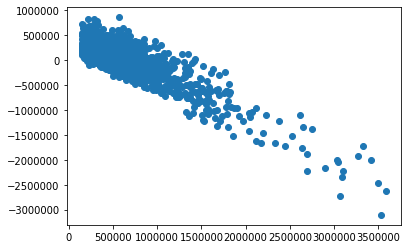

In [41]:
evaluate.plot_residuals(y_test, y_test_predictions_poly)

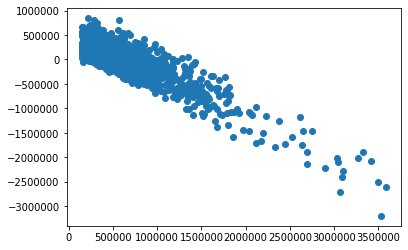

In [42]:
evaluate.plot_residuals(y_test, y_test_predictions_k2)

- Using the model that had the lowest RMSE not using bedrooms, simple_lm_k2, I predicted the test values, and got an RMSE of 358k, which is only slightly worse than 352k for the train data. 
- Using an ols model my test data resulted in an r2 statistic of .258, showing that a sizeable portion of the variance cannot be explained by the data.
- Finally, a plot of the residuals shows that because there is a discernable pattern, there is likely more to this data that might be extracted at a later time, or perhaps it would be better to use a nonlinear model to predict this data.
- With all of these factors taken into account, I say a better model is needed.

# Tax distributions

In [43]:
df.head()

,bathroom,bedroom,square_feet,tax,house_value,FIPS,county,state
2,3.000,4,2541,9819.720,880456,6059,Orange,CA
3,2.000,3,1650,7673.190,614000,6037,Los Angeles,CA
4,1.000,2,693,3267.470,274237,6037,Los Angeles,CA
6,2.000,3,1668,2376.340,196483,6059,Orange,CA
7,2.500,3,1653,6185.280,605000,6059,Orange,CA


In [44]:
df['tax_rate'] = df.tax / df.house_value
df.groupby('county').tax_rate.mean()

county
Los Angeles   0.013
Orange        0.012
Ventura       0.012
Name: tax_rate, dtype: float64

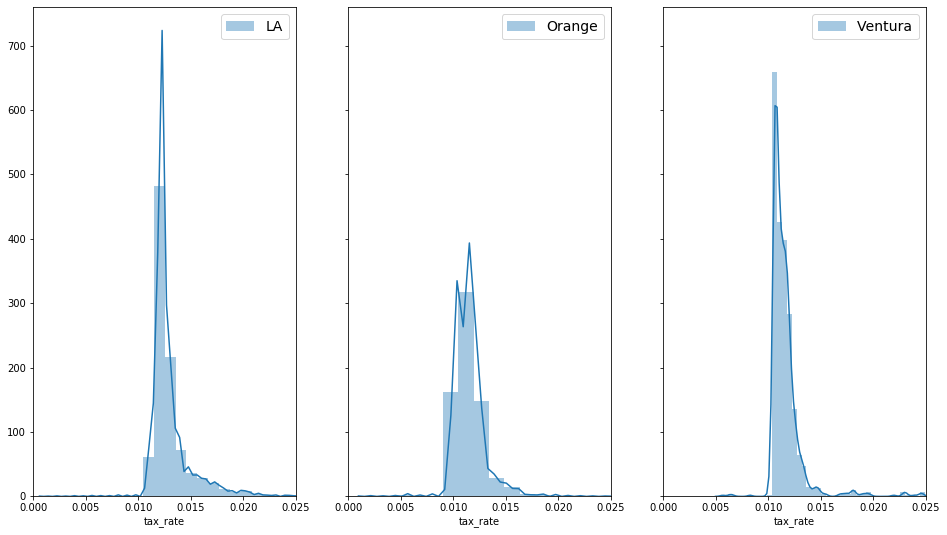

In [45]:
f, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(16,9))
sns.distplot(df.tax_rate[df.county == 'Los Angeles'], 
             label='LA', ax=axes[0])
sns.distplot(df.tax_rate[df.county == 'Orange'], 
             label='Orange', ax=axes[1])
sns.distplot(df.tax_rate[df.county == 'Ventura'], 
             label='Ventura', ax=axes[2])
plt.xlim(0,0.025)
axes[0].legend(fontsize=14), axes[1].legend(fontsize=14), \
    axes[2].legend(fontsize=14)
plt.show()